In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score
import seaborn as sns

np.random.seed(42)

In [ ]:
# ======================== DATA PREPARATION ========================
def load_linear_data(csv_path, val_size=0.2):
    """Load data for LINEAR regression (prediction)"""
    data = pd.read_csv(csv_path)
    X = data[['dim1', 'dim2', 'value']].values
    y = data['winning_bid'].values.reshape(-1, 1)  # Continuous target

    # Train-val split
    split_idx = int(len(X) * (1 - val_size))
    indices = np.random.permutation(len(X))

    X_train = np.hstack([np.ones((split_idx, 1)), X[indices[:split_idx]]])
    y_train = y[indices[:split_idx]]
    X_val = np.hstack([np.ones((len(X)-split_idx, 1)), X[indices[split_idx:]]])
    y_val = y[indices[split_idx:]]

    return X_train, y_train, X_val, y_val

def load_logistic_data(csv_path, val_size=0.2):
    """Load data for LOGISTIC regression (classification)"""
    data = pd.read_csv(csv_path)
    X = data[['Pregnancies', 'Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].values  # Change to your classification features
    y = (data['Outcome'] > 0).astype(int).values.reshape(-1, 1)

    # Train-val split
    split_idx = int(len(X) * (1 - val_size))
    indices = np.random.permutation(len(X))

    X_train = np.hstack([np.ones((split_idx, 1)), X[indices[:split_idx]]])
    y_train = y[indices[:split_idx]]
    X_val = np.hstack([np.ones((len(X)-split_idx, 1)), X[indices[split_idx:]]])
    y_val = y[indices[split_idx:]]

    return X_train, y_train, X_val, y_val

def visualize_linear_data(X, y, feature_names):
    """Visualize features vs continuous target"""
    plt.figure(figsize=(15, 5))
    for i in range(X.shape[1]-1):
        plt.subplot(1, X.shape[1]-1, i+1)
        plt.scatter(X[:, i+1], y, alpha=0.5)
        plt.xlabel(feature_names[i])
        plt.ylabel('Winning Bid')
    plt.tight_layout()
    plt.show()

def visualize_logistic_data(X, y, feature_names):
    """Visualize features vs binary classes"""
    plt.figure(figsize=(15, 5))
    for i in range(X.shape[1]-1):
        plt.subplot(1, X.shape[1]-1, i+1)
        plt.scatter(X[:, i+1], y, c=y, cmap='coolwarm', alpha=0.7)
        plt.xlabel(feature_names[i])
        plt.ylabel('Class (0/1)')
    plt.tight_layout()
    plt.show()

In [ ]:
"""Complete Linear & Logistic Regression Implementation (From Scratch vs Sklearn)"""

# ======================== LOGISTIC REGRESSION ========================
class LogisticRegressionScratch:
    """Logistic Regression from Scratch (Classification)"""

    @staticmethod
    def _sigmoid(z):
        """Sigmoid activation function"""
        # Clip extremely low/high values to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def compute_loss(X, y, theta, lambda_=0):
        """Compute binary cross-entropy loss with optional L2 regularization"""
        m = len(y)
        h = LogisticRegressionScratch._sigmoid(X @ theta)
        # Avoid log(0) by adding small epsilon
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)

        # Binary cross-entropy loss
        loss = (-y * np.log(h) - (1-y) * np.log(1-h)).mean()

        if lambda_ > 0:
            # Add L2 regularization term, exclude bias term (theta[0])
            reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
            return loss + reg_term
        return loss

    @staticmethod
    def batch_gd(X, y, theta, lr=0.01, epochs=1000):
        """Batch gradient descent"""
        losses = []
        m = len(y)
        for _ in range(epochs):
            h = LogisticRegressionScratch._sigmoid(X @ theta)
            grad = X.T @ (h - y) / m
            theta -= lr * grad
            losses.append(LogisticRegressionScratch.compute_loss(X, y, theta))
        return theta, losses

    @staticmethod
    def batch_gd_ridge(X, y, theta, lambda_=0.1, lr=0.01, epochs=1000):
        """Batch gradient descent with Ridge regularization"""
        losses = []
        m = len(y)
        for _ in range(epochs):
            h = LogisticRegressionScratch._sigmoid(X @ theta)

            # Gradient with regularization (don't regularize bias term)
            grad = X.T @ (h - y) / m

            # Add regularization term
            reg_term = np.copy(theta)
            reg_term[0] = 0  # Don't regularize bias term
            grad += (lambda_ / m) * reg_term

            theta -= lr * grad
            losses.append(LogisticRegressionScratch.compute_loss(X, y, theta, lambda_))
        return theta, losses

    @staticmethod
    def sgd(X, y, theta, lr=0.01, epochs=10):
        """Stochastic gradient descent"""
        losses = []
        m = len(y)

        for epoch in range(epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(m):
                xi = X_shuffled[i:i+1].T  # Single example as column vector
                yi = y_shuffled[i:i+1]    # Single target

                # Compute hypothesis for this example
                h = LogisticRegressionScratch._sigmoid(X_shuffled[i:i+1] @ theta)

                # Update using a single example
                grad = xi @ (h - yi)
                theta -= lr * grad

            # Compute loss after each epoch
            current_loss = LogisticRegressionScratch.compute_loss(X, y, theta)
            losses.append(current_loss)

        return theta, losses

    @staticmethod
    def sgd_ridge(X, y, theta, lambda_=0.1, lr=0.01, epochs=10):
        """Stochastic gradient descent with Ridge regularization"""
        losses = []
        m = len(y)

        for epoch in range(epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(m):
                xi = X_shuffled[i:i+1].T  # Single example as column vector
                yi = y_shuffled[i:i+1]    # Single target

                # Compute hypothesis for this example
                h = LogisticRegressionScratch._sigmoid(X_shuffled[i:i+1] @ theta)

                # Update using a single example with regularization
                grad = xi @ (h - yi)

                # Add regularization term
                reg_term = np.copy(theta)
                reg_term[0] = 0  # Don't regularize bias term
                grad += (lambda_ / m) * reg_term

                theta -= lr * grad

            # Compute loss after each epoch
            current_loss = LogisticRegressionScratch.compute_loss(X, y, theta, lambda_)
            losses.append(current_loss)

        return theta, losses

    @staticmethod
    def predict(X, theta, threshold=0.5):
        """Predict class labels (0 or 1)"""
        return (LogisticRegressionScratch._sigmoid(X @ theta) >= threshold).astype(int)





===== LOGISTIC REGRESSION (CLASSIFICATION) =====

=== Logistic Data Visualization ===


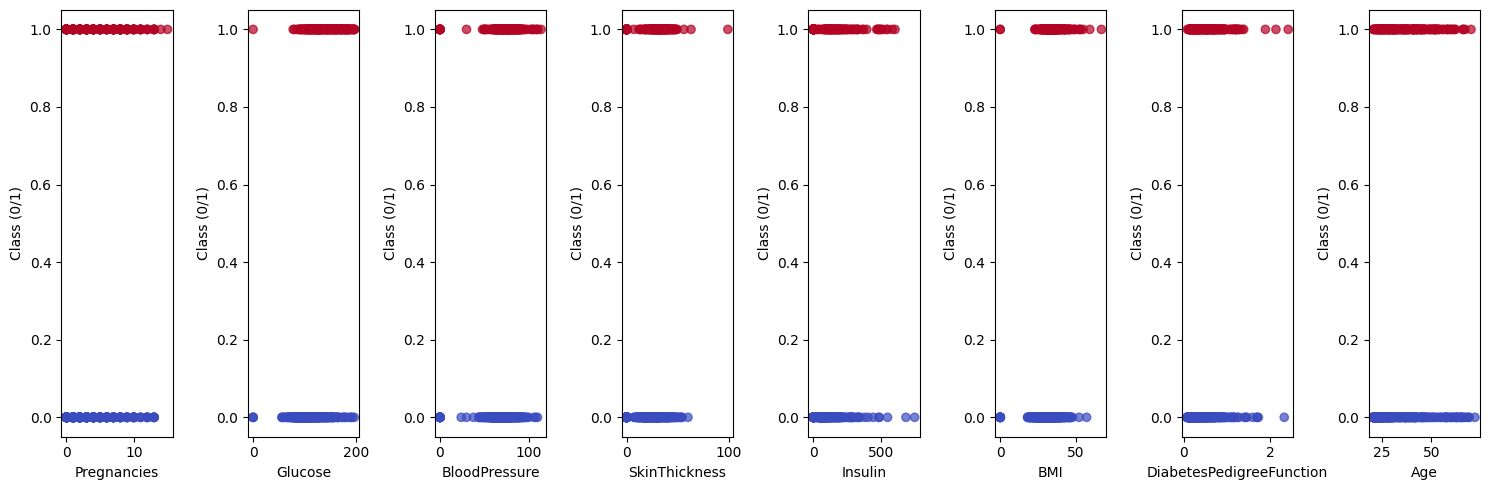


=== Logistic Regression with BCE Loss ===
Training Loss: 11.2222
Validation Accuracy: 0.6169

=== Logistic Regression with Ridge Regularization ===
Training Loss (Ridge): 12.8137
Validation Accuracy (Ridge): 0.4545

=== Logistic Regression with Stochastic Gradient Descent ===
Training Loss (SGD): 11.2871
Validation Accuracy (SGD): 0.6494

Sklearn Accuracy: 0.7532


In [ ]:
# ======================== MAIN EXECUTION ========================
if __name__ == "__main__":
    # ===== LOGISTIC REGRESSION (CLASSIFICATION) =====
    print("\n\n===== LOGISTIC REGRESSION (CLASSIFICATION) =====")
    logistic_data_path = "/content/diabetes.csv"  # Your classification dataset
    logistic_features = ['Pregnancies', 'Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']  # Change to your features

    # Load data
    X_train_log, y_train_log, X_val_log, y_val_log = load_logistic_data(logistic_data_path)

    # Visualize
    print("\n=== Logistic Data Visualization ===")
    visualize_logistic_data(X_train_log, y_train_log, logistic_features)

    # 1. Logistic Regression with loss only (Binary Cross-Entropy)
    print("\n=== Logistic Regression with BCE Loss ===")
    theta_log = np.zeros((X_train_log.shape[1], 1))
    theta_log, log_loss_val = LogisticRegressionScratch.batch_gd(X_train_log, y_train_log, theta_log)
    val_pred_log = LogisticRegressionScratch.predict(X_val_log, theta_log)
    val_accuracy = np.mean(val_pred_log == y_val_log)
    print(f"Training Loss: {log_loss_val[-1]:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # 2. Logistic Regression with Ridge Regularization
    print("\n=== Logistic Regression with Ridge Regularization ===")
    theta_log_ridge = np.zeros((X_train_log.shape[1], 1))
    theta_log_ridge, log_ridge_loss = LogisticRegressionScratch.batch_gd_ridge(
        X_train_log, y_train_log, theta_log_ridge, lambda_=0.1)
    val_pred_log_ridge = LogisticRegressionScratch.predict(X_val_log, theta_log_ridge)
    val_accuracy_ridge = np.mean(val_pred_log_ridge == y_val_log)
    print(f"Training Loss (Ridge): {log_ridge_loss[-1]:.4f}")
    print(f"Validation Accuracy (Ridge): {val_accuracy_ridge:.4f}")

    # 3a. Logistic Regression with Batch Gradient Descent
    # (Already implemented above)

    # 3b. Logistic Regression with Stochastic Gradient Descent
    print("\n=== Logistic Regression with Stochastic Gradient Descent ===")
    theta_log_sgd = np.zeros((X_train_log.shape[1], 1))
    theta_log_sgd, log_sgd_loss = LogisticRegressionScratch.sgd(
        X_train_log, y_train_log, theta_log_sgd, epochs=5)
    val_pred_log_sgd = LogisticRegressionScratch.predict(X_val_log, theta_log_sgd)
    val_accuracy_sgd = np.mean(val_pred_log_sgd == y_val_log)
    print(f"Training Loss (SGD): {log_sgd_loss[-1]:.4f}")
    print(f"Validation Accuracy (SGD): {val_accuracy_sgd:.4f}")

    # Sklearn comparison
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X_train_log[:, 1:], y_train_log.ravel())
    pred_log_sklearn = log_model.predict(X_val_log[:, 1:])
    print(f"\nSklearn Accuracy: {accuracy_score(y_val_log, pred_log_sklearn):.4f}")

In [ ]:
# ===== LINEAR REGRESSION (PREDICTION) =====
class LinearRegressionScratch:
    """Linear Regression from Scratch (Prediction)"""

    def __init__(self):
        self.theta = None
        self.mean = None
        self.std = None
        self.training_history = {
            'losses': [],
            'epochs': []
        }

    def standardize(self, X):
        """Standardize features except bias term"""
        if self.mean is None:
            self.mean = np.mean(X[:, 1:], axis=0)
            self.std = np.std(X[:, 1:], axis=0) + 1e-8

        X_scaled = X.copy()
        X_scaled[:, 1:] = (X[:, 1:] - self.mean) / self.std
        return X_scaled

    def compute_mse(self, X, y, theta, lambda_=0):
        """Compute MSE loss with optional regularization"""
        m = len(y)
        predictions = X @ theta
        mse = np.mean((predictions - y)**2) / 2
        if lambda_ > 0:
            reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
            return mse + reg_term
        return mse

    def batch_gd(self, X, y, lambda_=0, lr=0.01, epochs=1000):
        """Batch Gradient Descent"""
        X_scaled = self.standardize(X)
        m = len(y)
        self.theta = np.zeros((X.shape[1], 1))
        self.training_history['losses'] = []
        self.training_history['epochs'] = []

        for epoch in range(epochs):
            predictions = X_scaled @ self.theta
            grad = X_scaled.T @ (predictions - y) / m

            if lambda_ > 0:
                reg_grad = np.zeros_like(grad)
                reg_grad[1:] = (lambda_ / m) * self.theta[1:]
                grad += reg_grad

            self.theta -= lr * grad

            # Record training history
            loss = self.compute_mse(X_scaled, y, self.theta, lambda_)
            self.training_history['losses'].append(loss)
            self.training_history['epochs'].append(epoch)

            if epoch > 0 and abs(self.training_history['losses'][-1] - self.training_history['losses'][-2]) < 1e-8:
                break

        return self.training_history['losses']

    def sgd(self, X, y, lambda_=0, lr=0.01, epochs=10, batch_size=1):
        """Stochastic Gradient Descent"""
        X_scaled = self.standardize(X)
        m = len(y)
        self.theta = np.zeros((X.shape[1], 1))
        self.training_history['losses'] = []
        self.training_history['epochs'] = []

        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X_scaled[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                if i + batch_size > m:
                    break

                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                predictions = X_batch @ self.theta
                grad = X_batch.T @ (predictions - y_batch) / batch_size

                if lambda_ > 0:
                    reg_grad = np.zeros_like(grad)
                    reg_grad[1:] = (lambda_ / m) * self.theta[1:]
                    grad += reg_grad

                self.theta -= lr * grad

            # Record training history
            loss = self.compute_mse(X_scaled, y, self.theta, lambda_)
            self.training_history['losses'].append(loss)
            self.training_history['epochs'].append(epoch)

        return self.training_history['losses']

    def predict(self, X):
        """Make predictions on new data"""
        X_scaled = self.standardize(X)
        return X_scaled @ self.theta

    def plot_training_progress(self):
        """Plot training progress"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.training_history['epochs'], self.training_history['losses'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title('Training Progress')
        plt.grid(True)
        plt.show()

    def plot_predictions(self, X, y, title="Predictions vs Actual"):
        """Plot predictions against actual values"""
        predictions = self.predict(X)
        plt.figure(figsize=(10, 6))
        plt.scatter(y, predictions, alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predictions')
        plt.title(title)
        plt.grid(True)
        plt.show()

    def plot_residuals(self, X, y, title="Residuals Distribution"):
        """Plot residuals distribution"""
        predictions = self.predict(X)
        residuals = y - predictions
        plt.figure(figsize=(10, 6))
        plt.hist(residuals, bins=30, density=True, alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.title(title)
        plt.grid(True)
        plt.show()

def compare_models(models_dict, X_train, y_train, X_val, y_val):
    """Compare different models' performance"""
    plt.figure(figsize=(15, 5))

    # Plot training progress
    plt.subplot(131)
    for name, model in models_dict.items():
        plt.plot(model.training_history['epochs'],
                model.training_history['losses'],
                label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Progress Comparison')
    plt.legend()
    plt.grid(True)

    # Plot predictions comparison
    plt.subplot(132)
    for name, model in models_dict.items():
        train_pred = model.predict(X_train)
        plt.scatter(y_train, train_pred, alpha=0.5, label=name)
    plt.plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Predictions Comparison')
    plt.legend()
    plt.grid(True)

    # Plot validation performance
    plt.subplot(133)
    metrics = []
    for name, model in models_dict.items():
        val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, val_pred)
        r2 = r2_score(y_val, val_pred)
        metrics.append({'Model': name, 'MSE': mse, 'R²': r2})

    metrics_df = pd.DataFrame(metrics)
    metrics_df.plot(x='Model', y=['MSE', 'R²'], kind='bar')
    plt.title('Validation Metrics')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return metrics_df

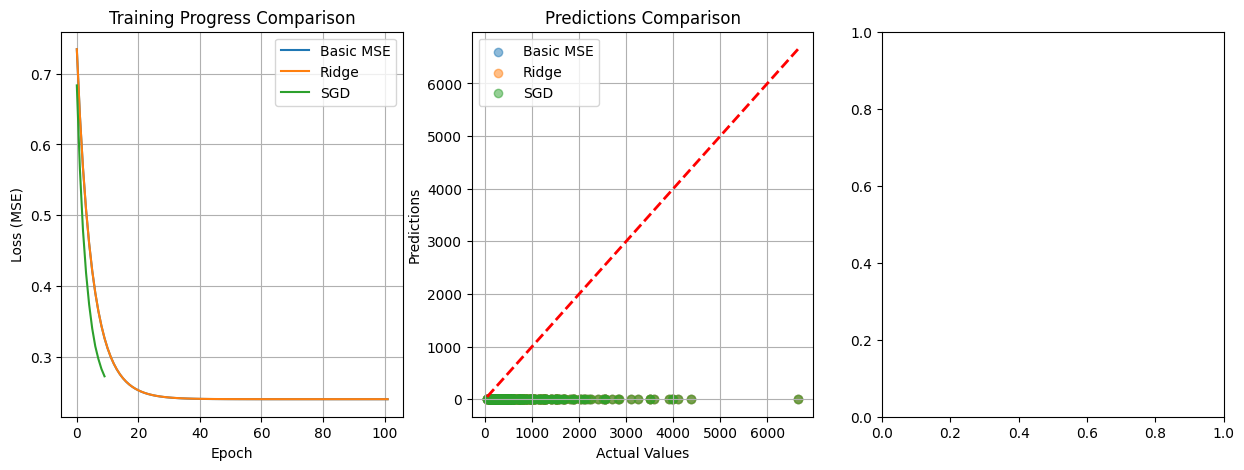

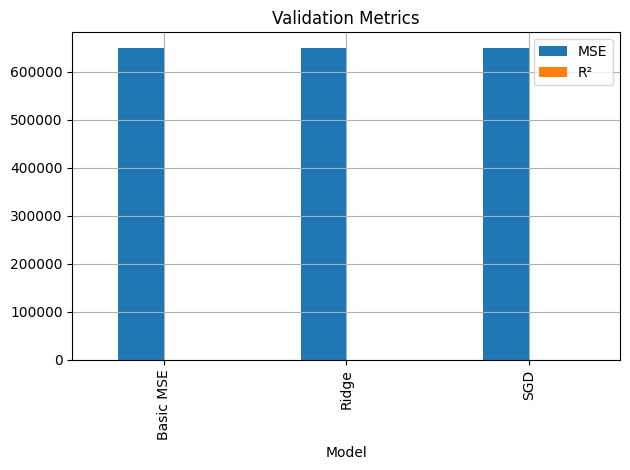


Model Performance Metrics:
       Model            MSE        R²
0  Basic MSE  649059.255923 -0.873323
1      Ridge  649059.370762 -0.873323
2        SGD  649364.002941 -0.874202

=== Basic MSE Analysis ===


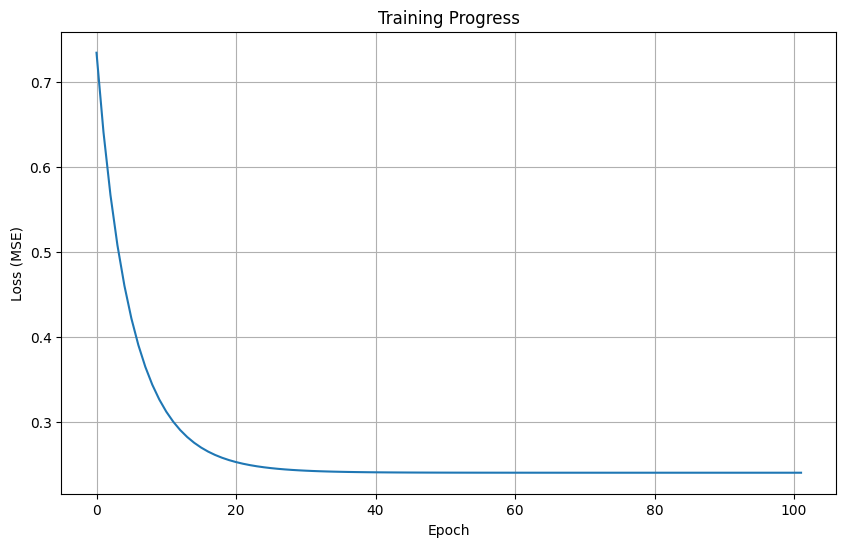

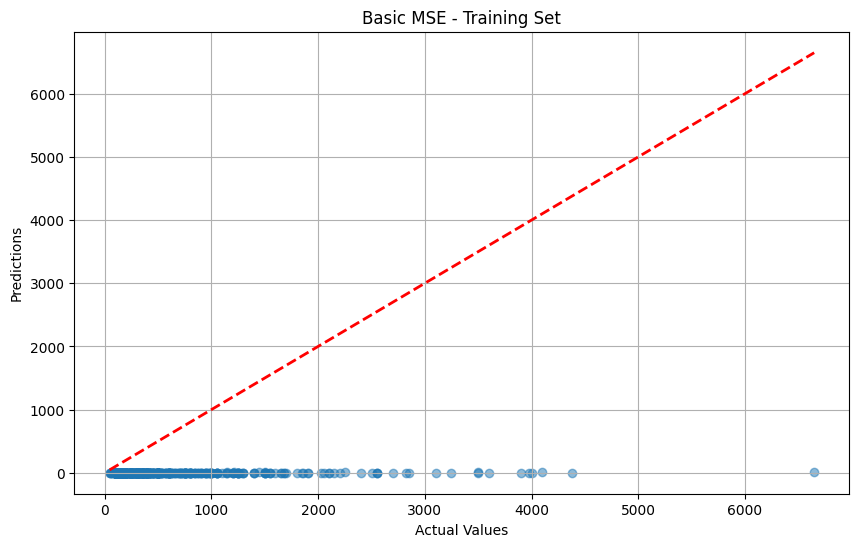

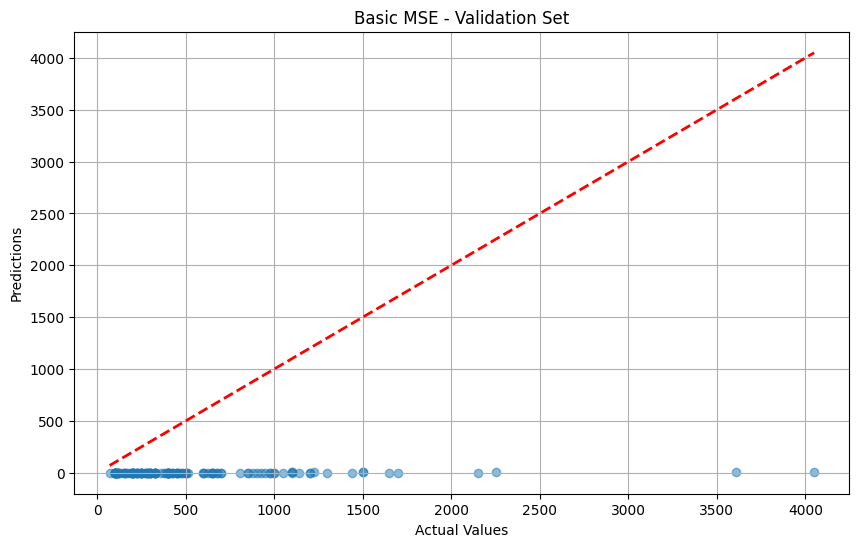

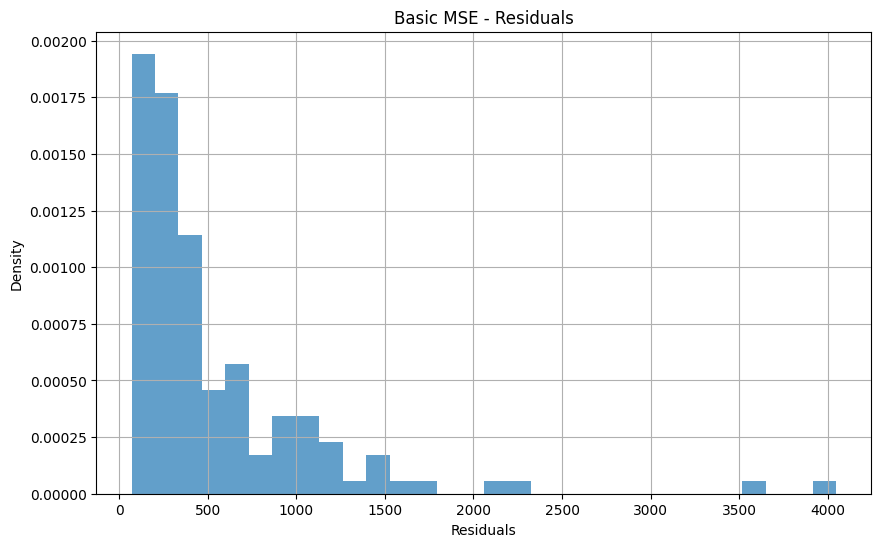


=== Ridge Analysis ===


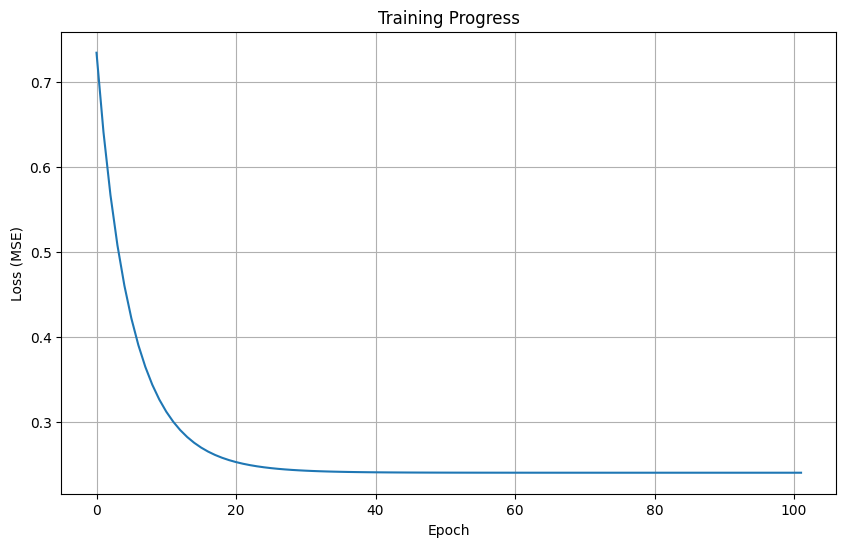

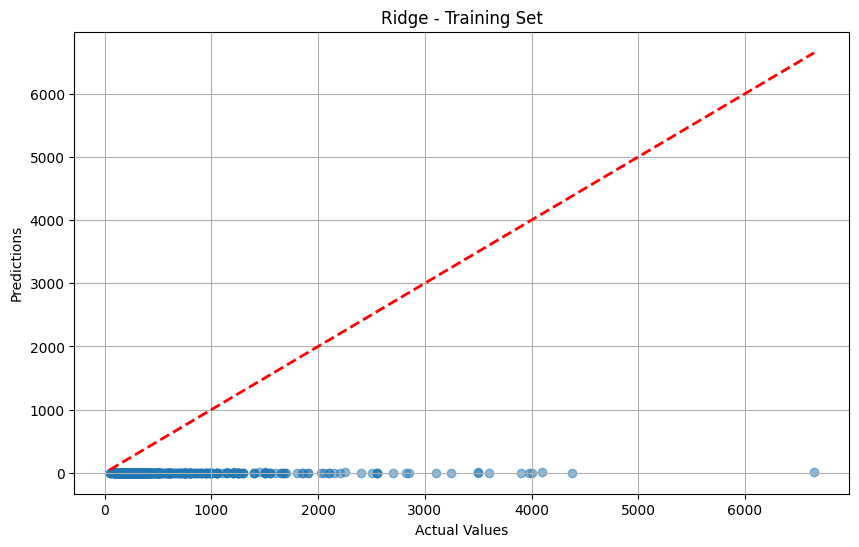

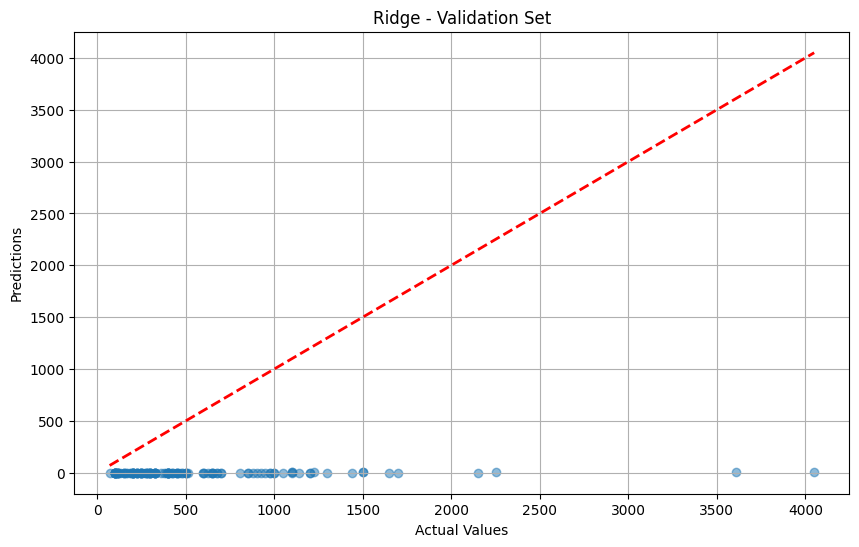

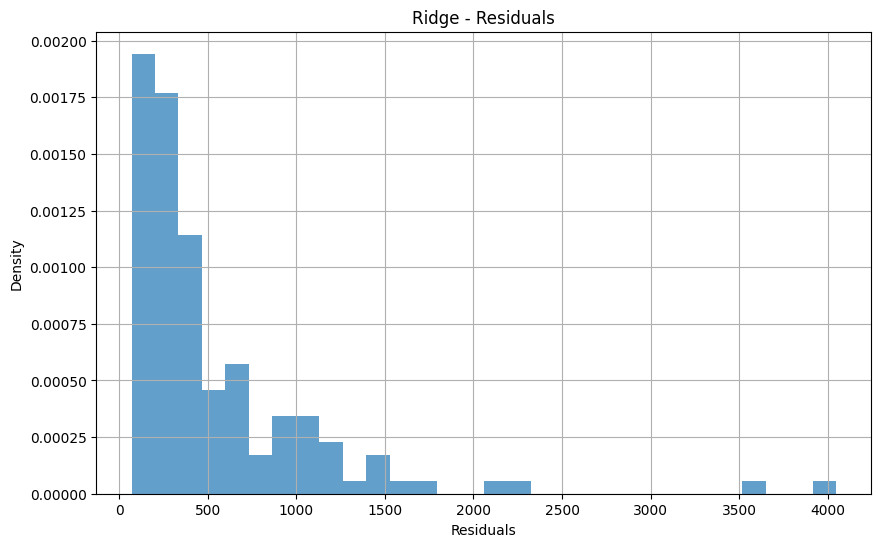


=== SGD Analysis ===


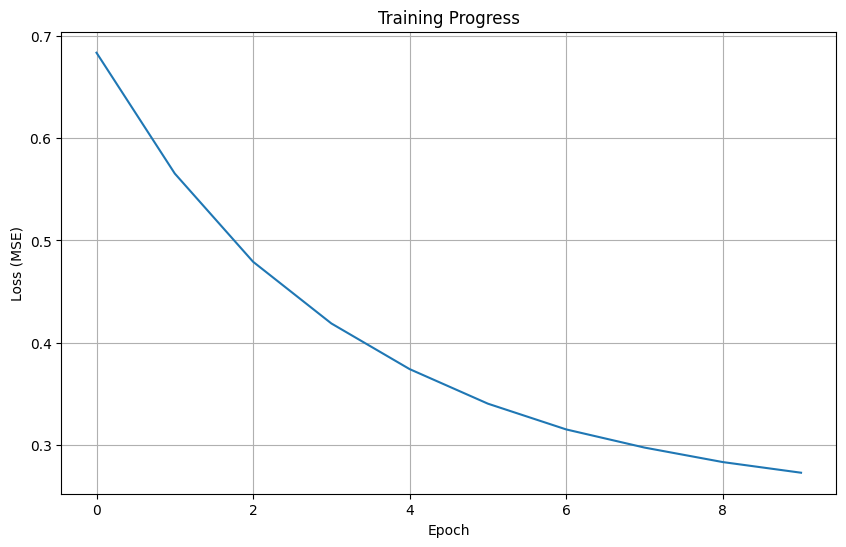

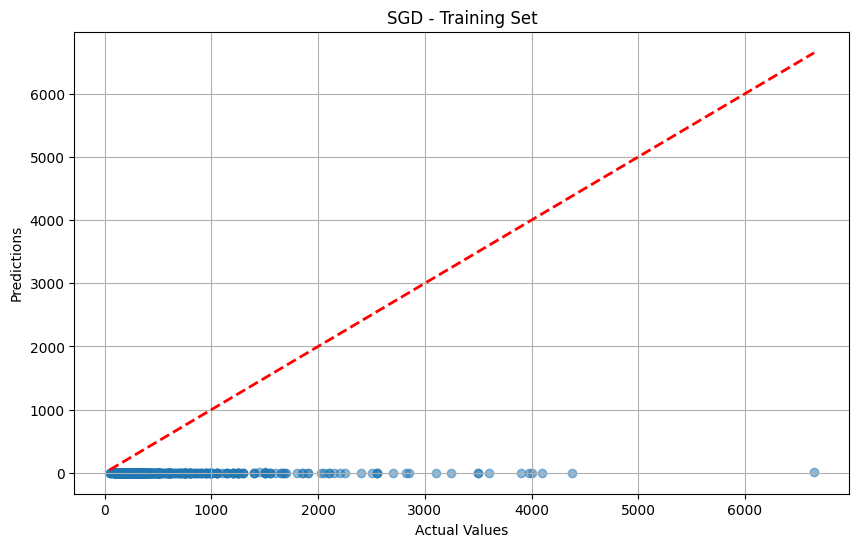

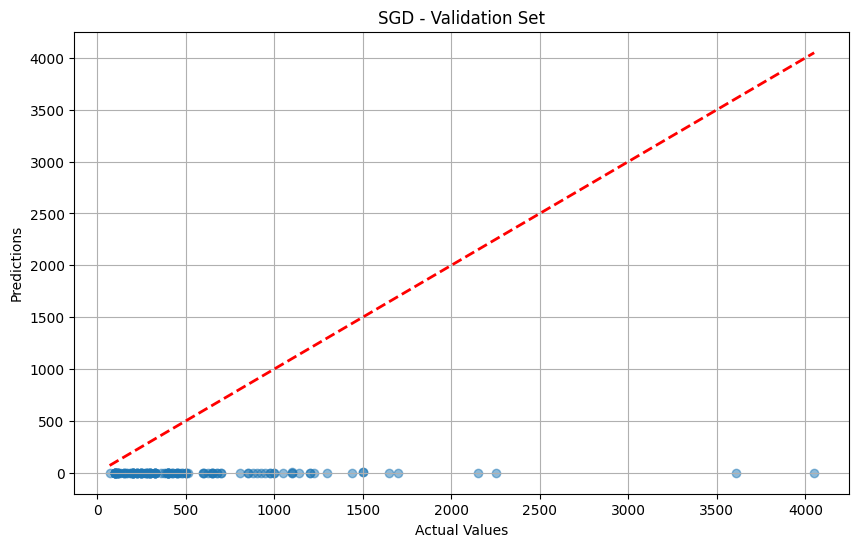

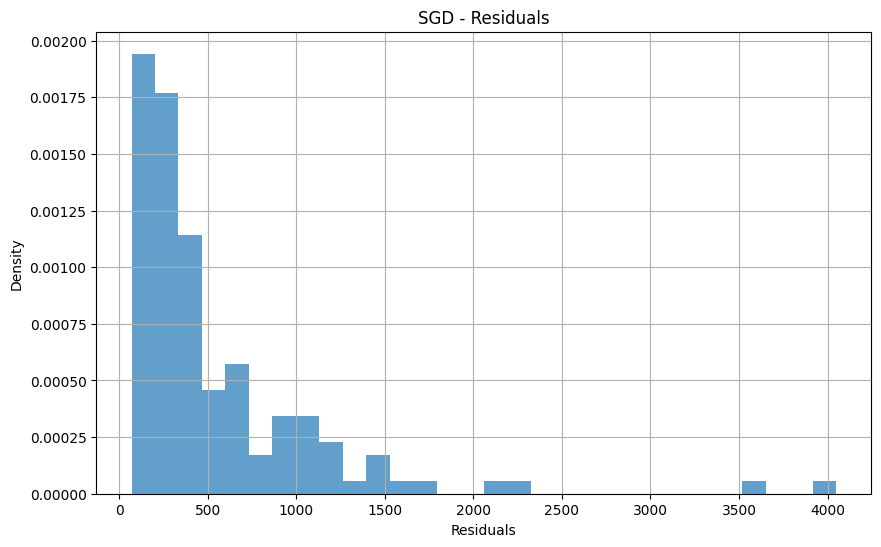

In [ ]:
if __name__ == "__main__":
    # Load and prepare data
    linear_data_path = "/content/train_original.csv"
    X_train_lin, y_train_lin, X_val_lin, y_val_lin = load_linear_data(linear_data_path)

    # Scale target variable
    y_scaler = np.std(y_train_lin) + 1e-8
    y_train_scaled = y_train_lin / y_scaler
    y_val_scaled = y_val_lin / y_scaler

    # Train models
    models = {
        'Basic MSE': LinearRegressionScratch(),
        'Ridge': LinearRegressionScratch(),
        'SGD': LinearRegressionScratch()
    }

    # Train each model
    models['Basic MSE'].batch_gd(X_train_lin, y_train_scaled, lr=0.1)
    models['Ridge'].batch_gd(X_train_lin, y_train_scaled, lambda_=0.1, lr=0.1)
    models['SGD'].sgd(X_train_lin, y_train_scaled, lr=0.01, batch_size=32)

    # Compare models
    metrics = compare_models(models, X_train_lin, y_train_lin, X_val_lin, y_val_lin)
    print("\nModel Performance Metrics:")
    print(metrics)

    # Individual model analysis
    for name, model in models.items():
        print(f"\n=== {name} Analysis ===")
        model.plot_training_progress()
        model.plot_predictions(X_train_lin, y_train_lin, f"{name} - Training Set")
        model.plot_predictions(X_val_lin, y_val_lin, f"{name} - Validation Set")
        model.plot_residuals(X_val_lin, y_val_lin, f"{name} - Residuals")